In [142]:
# 아웃포커싱 효과가 적용된 본인의 인물사진
import os
import urllib  # 웹에서 데이터 다운로드
import cv2  # OpenCV라이브러리로 이미지 처리
import numpy as np
from pixellib.semantic import semantic_segmentation  #pixellib:시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리
from matplotlib import pyplot as plt

(4032, 3024, 3)


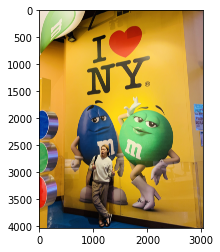

In [143]:
# 이미지 불러오기

img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/new_2.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [144]:
# 세그멘테이션

# PixelLib 모델 다운로드

# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f04de608730>)

In [145]:
# 사용할 세그멘테이션 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [146]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

In [147]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

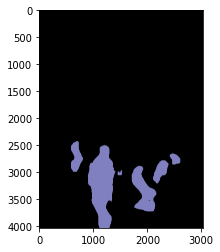

In [148]:
# 결과 확인
plt.imshow(output)
plt.show()

In [149]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [150]:
# label확인
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [151]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [152]:
colormap[15]

array([192, 128, 128])

In [153]:
seg_color = (128,128,192)

(4032, 3024)


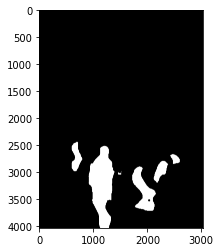

In [154]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

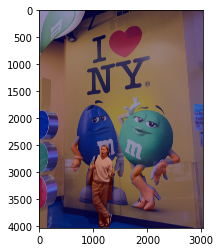

In [155]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

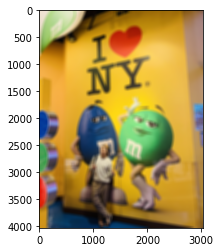

In [156]:
# 배경 흐리게
img_orig_blur = cv2.blur(img_orig, (70,70))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

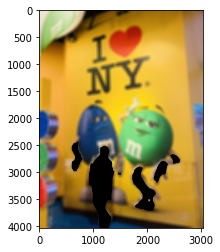

In [157]:
# 세그멘테이션 마스크를 이용해 배경만 추출

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

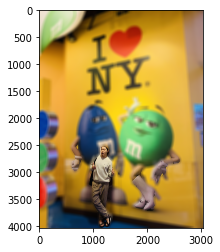

In [158]:
# 흐린 배경과 원본 영상 합성

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [159]:
# 문제점 & 솔루션
# 배경이 되는 그림의 팔과 다리를 인식하였지만 나름 만족스러운 결과이다. 문제를 해결하기 위해서, 이미지 사이즈를 키우고 다시 시맨틱 세그멘테이션을 하면 좀 더 정확한 결과를 얻을 수 있을 것이라고 생각한다.
# 또한, '가우시안 블러'를 사용한다면 경계가 자연스러워질것이다. 

In [160]:
# 아웃포커싱 효과가 적용된 고양이 사진

(852, 1280, 3)


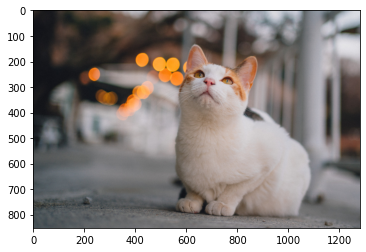

In [161]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpg'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [162]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

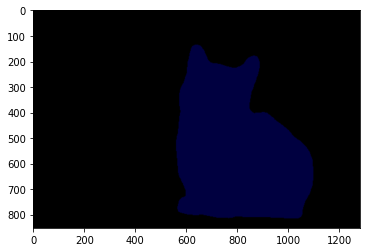

In [163]:
plt.imshow(output)
plt.show()

In [164]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


In [165]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[8]

array([64,  0,  0])

In [166]:
seg_color = (0,0,64)

(852, 1280)


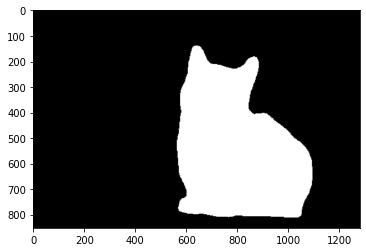

In [167]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

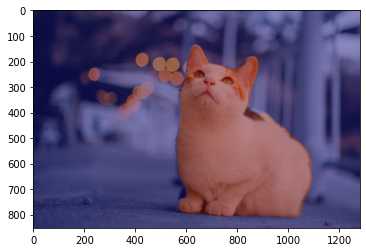

In [168]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

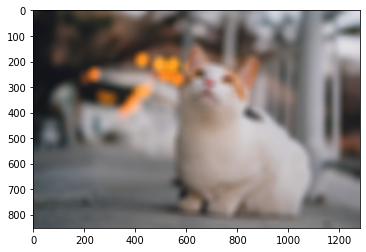

In [169]:
# 배경 흐리게
img_orig_blur = cv2.blur(img_orig, (30,30))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

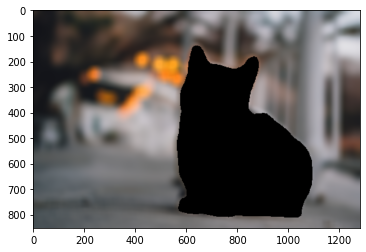

In [170]:
# 세그멘테이션 마스크를 이용해 배경만 추출

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

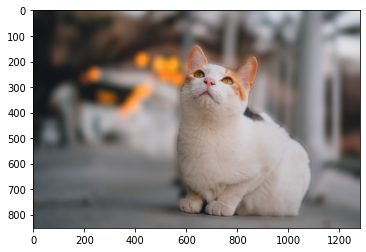

In [171]:
# 흐린 배경과 원본 영상 합성
 
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [172]:
# 문제점 & 솔루션
# 역시 기본 데이터의 중요성을 느끼는 결과물이다. 귀엽다.

In [173]:
# 배경전환 크로마키사진

(852, 1280, 3)


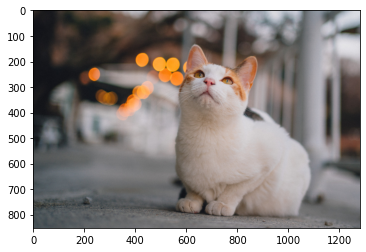

In [174]:
#고양이사진
cat_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.png'  
cat_img_orig = cv2.imread(cat_img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

(337, 511, 3)


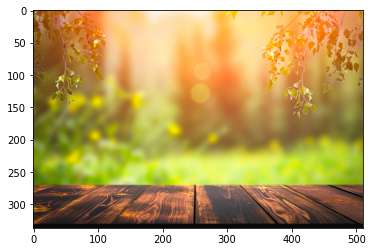

In [175]:
#배경사진
b_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/background.jpg'  
b_img_orig = cv2.imread(b_img_path) 

print(b_img_orig.shape)
plt.imshow(cv2.cvtColor(b_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

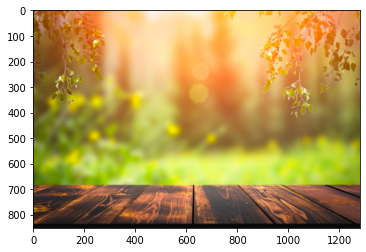

In [176]:
b_img_orig_resize = cv2.resize(b_img_orig,(img_orig.shape[1], img_orig.shape[0]))
plt.imshow(cv2.cvtColor(b_img_orig_resize , cv2.COLOR_BGR2RGB))
plt.show()

In [177]:
#모델에 이미지 입력
cat_segvalues, cat_output = model.segmentAsPascalvoc(img_path)

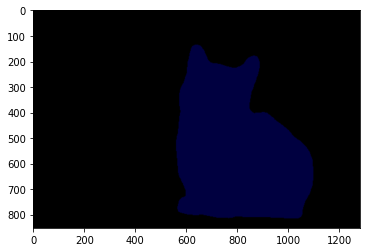

In [178]:
plt.imshow(cat_output)
plt.show()

In [179]:
for class_id in cat_segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


In [180]:
cat_seg_color = (0,0,64)

(852, 1280)


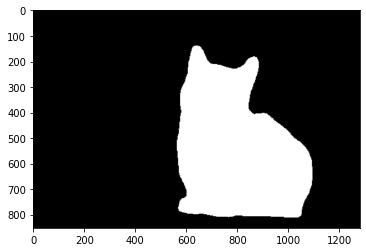

In [181]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
cat_seg_map = np.all(cat_output==cat_seg_color, axis=-1)
print(cat_seg_map.shape)
plt.imshow(cat_seg_map, cmap='gray')
plt.show()

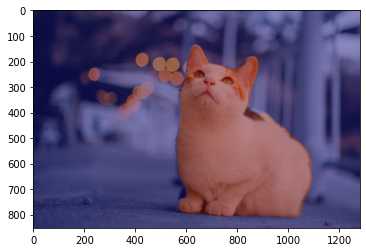

In [182]:
cat_img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
cat_img_mask = cat_seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
cat_color_mask = cv2.applyColorMap(cat_img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
cat_img_show = cv2.addWeighted(cat_img_show, 0.6, cat_color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(cat_img_show, cv2.COLOR_BGR2RGB))
plt.show()

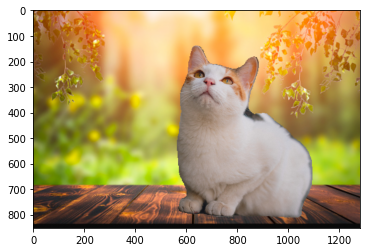

In [183]:
#세그멘테이션 마스크를 이용해 배경만 추출

cat_img_mask_color = cv2.cvtColor(cat_img_mask, cv2.COLOR_GRAY2BGR)
b_img_concat = np.where(cat_img_mask_color==255, img_orig, b_img_orig_resize)

plt.imshow(cv2.cvtColor(b_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [184]:
# 문제점 & 솔루션
# 영역이 잘 인식되어 주변 배경이 함께 합성되지 않고 자연스럽게 합성되었다.
# 사랑스러운 고양이에게 따뜻한 배경을 완벽한 사진이다.

**회고**

사진을 건드리는 프로젝트는 항상 흥미롭다. 그만큼 다른 익스보다는 난이도가 낮지만, 생활 속에서 자주 사용하는 인물사진용 블러를 직접 합성해보는 프로젝트라서 더욱 재미있었다.
예상한 것보다, 블러 처리한 사진도 자연스럽고, 크로마키에 누끼를 딴 고양이도 자연스러웠다. 문제점을 많이 발견해서 솔루션을 잔뜩 찾아보고 싶었지만, 다음에는 좀 더 부자연스러운 사진들로 프로젝트를 진행해봐야겠다. 귀여운 고양이를 봐서 재미있었다. 사진을 가지고 실습하는 프로젝트가 제일 부담감도 없고 재미있어서 이것저것 내 사진들을 많이 테스트해보고 하나를 골라서 제출한다는 점이 은근 재미있다.